---

<h1><center><font color='#82ad32'>Gasto Público em Educação x Desempenho no PISA</font></center></h1>

---

O objetivo deste trabalho é avaliar possíveis correlações entre o gasto público de um país em educação e o desempenho dos alunos deste país na prova do Programa Internacional de Avaliação de Estudantes (PISA). Todas as informações necessárias foram baixadas no site de dados da OCDE [aqui](https://data.oecd.org/), onde é possível encontrar o histórico dos indicadores pertinentes em formato ```.csv```. 

Vale notar que por gasto público em educação nos referimos à porcentagem do PIB investida pelo país na educação primária e secundária. O desempenho do país no PISA, por sua vez, faz referência à nota de cada país na prova e está dividido em três bases, uma para cada área do conhecimento avaliada: Leitura, Matemática e Ciência. Maiores informações a respeito do PISA podem ser encontradas [aqui](http://portal.inep.gov.br/pisa), no site do INEP.

### <font color='#82ad32'>Divisão do Trabalho</font>

0. Importação das Bibliotecas
1. Input das Bases
2. Tratamento das Bases
3. Unificação das Bases
4. Análise Exploratória dos Dados
5. Correlação entre Gasto Público em Educação x Desempenho no PISA


---

## <font color='#82ad32'>0. Importação das Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import matplotlib.gridspec as gridspec

---

## <font color='#82ad32'>1. Input das Bases

In [2]:
# Gasto Público em Educação
gp_educ = pd.read_csv('gasto_publico_educ_00-15.csv')

# Desempenho no PISA
# Matemática
pisa_m = pd.read_csv('pisa_mat_03-18.csv')
# Leitura
pisa_l = pd.read_csv('pisa_leitura_00-18.csv')
# Ciência
pisa_c = pd.read_csv('pisa_sci_06-18.csv')

# Chaves para cruzar os dados com seus paises e Continentes
gapminder_keys = px.data.gapminder()[['country', 
                                      'continent', 
                                      'iso_alpha']
                                    ].drop_duplicates().reset_index(drop=True)

---

## <font color='#82ad32'>2. Tratamento das Bases

In [4]:
#Selecionando apenas colunas pertinentes
gp_educ.drop(['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)

pisa_m.drop( ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)
pisa_l.drop( ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)
pisa_c.drop( ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)

#Com isso, todas as bases contêm apenas o nome do país, o valor do indicador e o ano.

In [6]:
#Renomeando as colunas para maior comodidade 
gp_educ.columns = ['country','Ano','Gasto Educ (%)']
pisa_m.columns  = ['country','Ano','Nota Matemática']
pisa_l.columns  = ['country','Ano','Nota Leitura']
pisa_c.columns  = ['country','Ano','Nota Ciências']

gapminder_keys.columns = ['País', 'Continente', 'country'] # country vira o iso_alpha

In [7]:
#Avaliando se as colunas estão sendo lidas corretamente. Ano e Valor devem ser lidos como números inteiros (int)
#ou fracionados (float)

print(gp_educ.dtypes)
print()
print(pisa_m.dtypes)
print()
print(pisa_c.dtypes)
print()
print(pisa_l.dtypes)

country            object
Ano                 int64
Gasto Educ (%)    float64
dtype: object

country            object
Ano                 int64
Nota Matemática     int64
dtype: object

country          object
Ano               int64
Nota Ciências     int64
dtype: object

country         object
Ano              int64
Nota Leitura     int64
dtype: object


---

## <font color='#82ad32'>3. Unificação das Bases

In [8]:
#Para unificar as bases, precisamos de uma coluna para usar de referência. Como os valores fazem referência a um país e a um ano
#simultaneamente, vamos concatenar a coluna país com a coluna ano. Com isso, essa coluna concatenada poderá ser usada para 
#cruzar as bases sem perda de informação.

gp_educ['País-Ano'] = gp_educ['country'] + '-' + gp_educ['Ano'].astype(str)

pisa_m['País-Ano']  = pisa_m['country']  + '-' + pisa_m['Ano'].astype(str)
pisa_l['País-Ano']  = pisa_l['country']  + '-' + pisa_l['Ano'].astype(str)
pisa_c['País-Ano']  = pisa_c['country']  + '-' + pisa_c['Ano'].astype(str)

In [9]:
#Concatenando as bases
base = pd.concat([gp_educ,pisa_m,pisa_l,pisa_c],axis=0,sort=False)
#Com isso, a variável 'base' estará agrupada, mas terá valores repetidos para o país-ano 
#(duas linhas para Brasil-2005, por exemplo)

#Para termos apenas um valor para cada país-ano, vamos agrupar a base na coluna País-Ano utilizando como função a mínimo. 
#Poderíamos aqui utilizar outras funções que não a mínimo, pois só existe 1 valor de cada indicador para cada país-ano.
#Se fizessemos a função max(), por exemplo, o resultado seria o mesmo, pois o mínimo de [nan,nan,x] é igual ao
#máximo de [nan,nan,x], já que só possui um valor - nan não conta.

base_group = base.groupby('País-Ano').min()

base_group = base_group.merge(gapminder_keys, on='country', how='left')

---

## <font color='#82ad32'>4. Análise Exploratória dos Dados

Nesta seção, vamos buscar entender o comportamento das bases. Antes de mais nada, veremos quais são as estatísticas descritivas da base.

In [12]:
base_group.describe()[['Gasto Educ (%)', 'Nota Matemática', 'Nota Leitura','Nota Ciências']]

#Antes de mais nada, percebemos que o count das colunas não é igual. Isto significa que não existem todos os indicadores,
#todos os anos para todos os países. Isto é um problema, pois implica que precisaremos lidar com esses espaços vazios.

#Quanto ao Gasto Público em educação, percebemos que existe uma amplitude grande - de 1.5% à 5.1% de investimento -, com uma 
#média de 3.29%

#Já as notas do PISA possuem médias muito parecidas, entre 485 e 490 pontos.

,Gasto Educ (%),Nota Matemática,Nota Leitura,Nota Ciências
count,378.000000,242.000000,270.000000,207.000000
mean,3.296735,488.107438,487.051852,491.352657
std,0.686690,41.439613,34.827417,36.545573
min,1.543000,356.000000,371.000000,382.000000
25%,2.754250,481.000000,476.000000,479.500000
50%,3.242000,495.000000,494.000000,498.000000
75%,3.744250,514.000000,507.750000,514.500000
max,5.158000,564.000000,556.000000,563.000000


Text(0.5, 0.98, 'Distribuição das Variáveis')

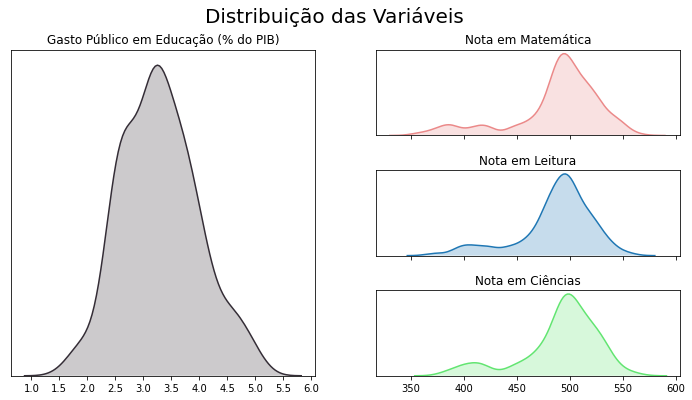

In [13]:
#Vamos visualizar as distribuições dessas colunas.
fig = plt.figure(figsize=(12,6))

#Gerando um espaço de imagem do matplotlib
gs = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.4,figure=fig)

#Criando os sub-espaços (1 maior, e 3 menores)
#No código abaixo estamos forçando os gráficos do PISA a terem todos os mesmo eixo X.
ax0 = fig.add_subplot(gs[0, 1])
plt.yticks([])
plt.yticks([])
plt.title('Nota em Matemática')
plt.setp(ax0.get_xticklabels(), visible=False)

ax1 = fig.add_subplot(gs[1, 1],sharex=ax0)
plt.yticks([])
plt.title('Nota em Leitura')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(gs[2, 1],sharex=ax0)
plt.yticks([])
plt.title('Nota em Ciências')

ax3 = fig.add_subplot(gs[:, 0])
plt.yticks([])
plt.xticks([x/100 for x in range(100,700,50)])
plt.title('Gasto Público em Educação (% do PIB)')

#Plotando os gráficos de distribuição.
sns.distplot(base_group['Gasto Educ (%)'],ax=ax3,hist=False,axlabel=False,kde_kws={"shade": True},color='#342d36')
sns.distplot(base_group['Nota Matemática'],ax=ax0,hist=False,axlabel=False,kde_kws={"shade": True},color='#eb8989')
sns.distplot(base_group['Nota Leitura'],ax=ax1,hist=False,kde_kws={"shade": True},axlabel=False)
sns.distplot(base_group['Nota Ciências'],ax=ax2,hist=False,axlabel=False,kde_kws={"shade": True},color='#62e571')

fig.suptitle('Distribuição das Variáveis',fontsize=20)

---

# <font color='#82ad32'>5. Correlação entre Gasto Público em Educação x Desempenho no PISA

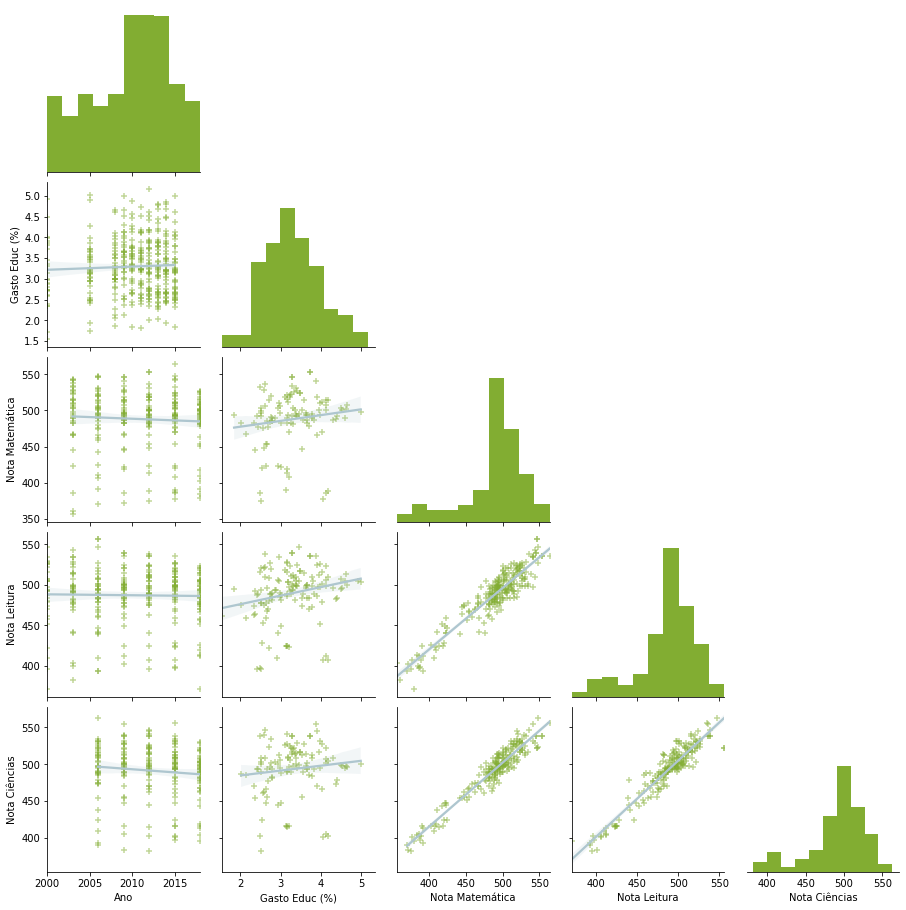

In [38]:
g = sns.pairplot(base_group, 
                 markers="+",
                 kind='reg',
                 diag_kind='hist',
                 palette='Viridis',
                 diag_kws={'color': '#82ad32'},
                 plot_kws={'line_kws':{'color':'#aec6cf'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#82ad32'}}, 
#                            'diag_kws': {'color': '#82ad32'}}, # abri uma questao: https://stackoverflow.com/questions/62617588/change-the-seaborn-pairplot-diagonal-color
                 corner=True)

### <font color='#FGG99'>Ano
    
  • Podemos ver em [1,1] que a maioria dos registros estao entre 2010 e 2015; 

  • Pela linha de regressao linear contra as vari'aveis ```['Gasto Educ (%)', 'Nota Matemática', 'Nota Leitura', 'Nota Ciências']``` podemos notar que mesmo com os gastos p'ublicos com a educacao aumentando nos ultimos anos, os resultados das notas vem diminuindo.
    
### <font color='#FGG99'>Gasto Educ (%)

  • Podemos ver em [2,2] que a maioria dos gastos em educacao foram entre 2 a 4% do PIB, temos que investigar se houve alguma tendencia ou sempre foi assim;

  • Pela linha de regressao linear contra as vari'aveis ```['Nota Matemática', 'Nota Leitura', 'Nota Ciências']``` podemos notar que os gastos educacionais estao correlacionados com um aumento do desempenho na notas, porem faz contraponto com a analise de Ano.
        
### <font color='#FGG99'>Notas Matemática, Leitura e Ciencias

  • Podemos ver em [[3,3], [4,4], [5,5]] que a maioria dos registros estao entre 475 a 525 pontos; 
    
  • Pela linha de regressao linear vemos que a correlacao dos desempenhos 'e linear quase perfeita, indicando uma causalidade, possivelmente explicada pelo modelo de ensino no qual essas areas do conhecimento tendem a ter a mesma qualidade para os mesmos grupos de alunos.

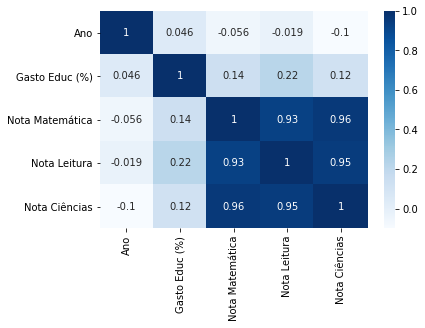

In [16]:
sns.heatmap(base_group.corr(), annot=True, cmap='Blues')

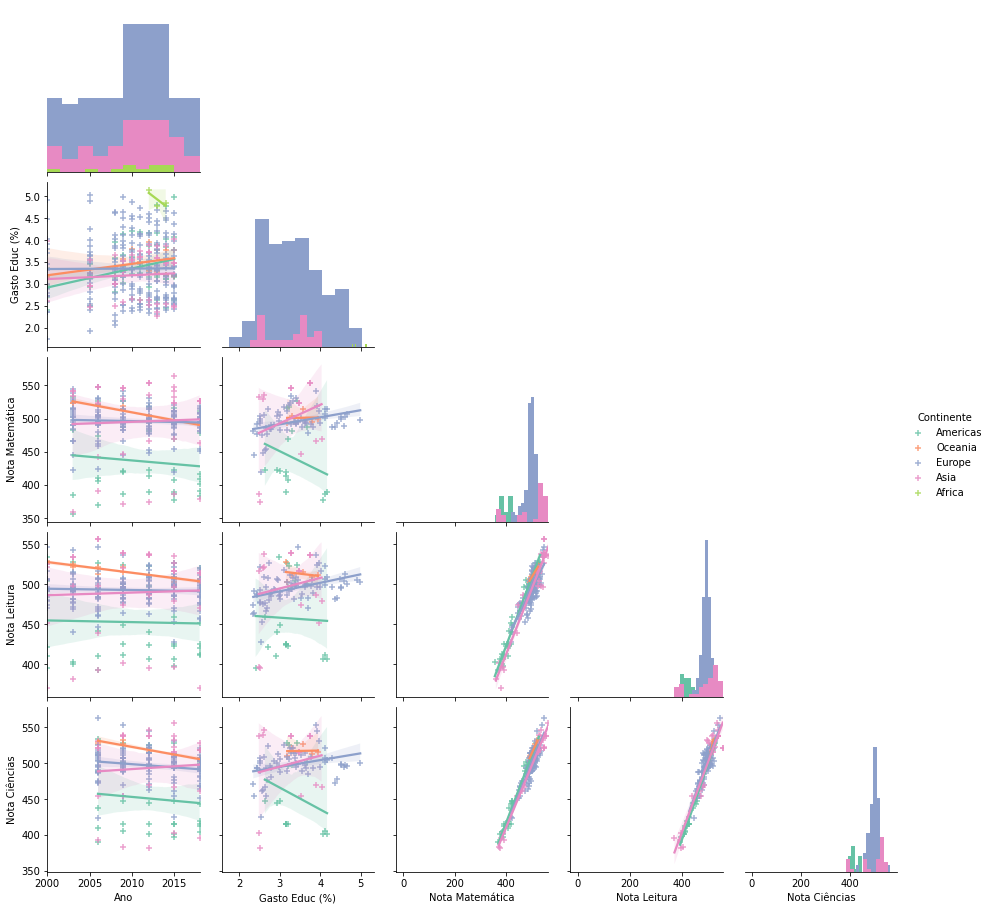

In [45]:
g = sns.pairplot(base_group, 
                 markers="+",
                 kind='reg',
                 diag_kind='hist',
                 hue='Continente',
                 palette=sns.color_palette("Set2"),
#                  plot_kws={'line_kws':{'color':'#aec6cf'}}, 
#                            'diag_kws': {'color': '#82ad32'}}, # abri uma questao: https://stackoverflow.com/questions/62617588/change-the-seaborn-pairplot-diagonal-color
                 corner=True)

---
---

# <font color='#82ad32'>Testes

### <font color='#82ad32'>Análise por país 
    
    teste

In [11]:
base_group.groupby('Ano').describe().T

Ano                          2000        2003       2005        2006  \
Gasto Educ (%)  count   28.000000    0.000000  36.000000    0.000000   
                mean     3.105571         NaN   3.241667         NaN   
                std      0.780224         NaN   0.694592         NaN   
                min      1.543000         NaN   1.746000         NaN   
                25%      2.676250         NaN   2.906000         NaN   
                50%      2.937500         NaN   3.206000         NaN   
                75%      3.733750         NaN   3.587000         NaN   
                max      4.921000         NaN   5.031000         NaN   
Nota Matemática count    0.000000   33.000000   0.000000   39.000000   
                mean          NaN  489.575758        NaN  487.641026   
                std           NaN   48.178723        NaN   41.296417   
                min           NaN  356.000000        NaN  370.000000   
                25%           NaN  483.000000        NaN  475.000000   
                50%           NaN  503.000000        NaN  495.000000   
                75%           NaN  523.000000        NaN  514.000000   
                max           NaN  544.000000        NaN  548.000000   
Nota Leitura    count   31.000000   33.000000   0.000000   37.000000   
                mean   486.064516  485.969697        NaN  482.189189   
                std     41.373047   36.953082        NaN   36.625612   
                min    371.000000  382.000000        NaN  393.000000   
                25%    472.000000  478.000000        NaN  466.000000   
                50%    493.000000  492.000000        NaN  488.000000   
                75%    511.500000  507.000000        NaN  501.000000   
                max    546.000000  543.000000        NaN  556.000000   
Nota Ciências   count    0.000000    0.000000   0.000000   39.000000   
                mean          NaN         NaN        NaN  492.025641   
                std           NaN         NaN        NaN   38.276341   
                min           NaN         NaN        NaN  390.000000   
                25%           NaN         NaN        NaN  482.000000   
                50%           NaN         NaN        NaN  498.000000   
                75%           NaN         NaN        NaN  515.500000   
                max           NaN         NaN        NaN  563.000000   

Ano                         2008        2009       2010       2011  \
Gasto Educ (%)  count  34.000000   34.000000  35.000000  35.000000   
                mean    3.243765    3.490735   3.409743   3.304371   
                std     0.662192    0.655540   0.660031   0.646487   
                min     1.864000    2.134000   1.849000   1.822000   
                25%     2.934750    3.160250   2.972500   2.860500   
                50%     3.202500    3.530000   3.360000   3.242000   
                75%     3.644250    3.873250   3.764500   3.672500   
                max     4.649000    4.989000   4.866000   4.732000   
Nota Matemática count   0.000000   38.000000   0.000000   0.000000   
                mean         NaN  488.394737        NaN        NaN   
                std          NaN   38.743466        NaN        NaN   
                min          NaN  371.000000        NaN        NaN   
                25%          NaN  483.000000        NaN        NaN   
                50%          NaN  494.500000        NaN        NaN   
                75%          NaN  512.750000        NaN        NaN   
                max          NaN  546.000000        NaN        NaN   
Nota Leitura    count   0.000000   37.000000   0.000000   0.000000   
                mean         NaN  488.135135        NaN        NaN   
                std          NaN   29.834881        NaN        NaN   
                min          NaN  402.000000        NaN        NaN   
                25%          NaN  478.000000        NaN        NaN   
                50%          NaN  495.000000        NaN        NaN   
             

situacao da africa eh triste, so podemos analisar as financas; talvez seja melhor retirar do estudo. vamos tirar la no inicio

In [20]:
base_group.groupby('Continente').describe().T

Continente                  Africa     Americas         Asia       Europe  \
Ano             count    10.000000    97.000000    97.000000   297.000000   
                mean   2009.700000  2009.886598  2009.824742  2009.582492   
                std       4.522782     4.817235     4.730245     4.888012   
                min    2000.000000  2000.000000  2000.000000  2000.000000   
                25%    2008.250000  2006.000000  2006.000000  2006.000000   
                50%    2010.500000  2010.000000  2010.000000  2010.000000   
                75%    2012.750000  2013.000000  2013.000000  2013.000000   
                max    2015.000000  2018.000000  2018.000000  2018.000000   
Gasto Educ (%)  count     3.000000    59.000000    42.000000   214.000000   
                mean      4.931000     3.362814     3.200071     3.348991   
                std       0.201343     0.577394     0.546838     0.712867   
                min       4.774000     2.400000     2.270000     1.730000   
                25%       4.817500     3.065500     2.606500     2.728000   
                50%       4.861000     3.208000     3.469000     3.308500   
                75%       5.009500     3.634500     3.613000     3.864250   
                max       5.158000     4.995000     4.033000     5.031000   
Nota Matemática count     0.000000    33.000000    32.000000   135.000000   
                mean           NaN   435.515152   495.718750   496.162963   
                std            NaN    53.793076    65.905227    22.647595   
                min            NaN   356.000000   360.000000   420.000000   
                25%            NaN   390.000000   459.000000   487.000000   
                50%            NaN   417.000000   526.500000   498.000000   
                75%            NaN   481.000000   543.000000   509.000000   
                max            NaN   532.000000   564.000000   548.000000   
Nota Leitura    count     0.000000    37.000000    37.000000   152.000000   
                mean           NaN   452.729730   489.432432   492.861842   
                std            NaN    48.672744    56.470022    18.724581   
                min            NaN   393.000000   371.000000   428.000000   
                25%            NaN   412.000000   470.000000   483.000000   
                50%            NaN   426.000000   514.000000   494.000000   
                75%            NaN   500.000000   534.000000   504.250000   
                max            NaN   534.000000   556.000000   547.000000   
Nota Ciências   count     0.000000    29.000000    28.000000   114.000000   
                mean           NaN   450.379310   493.785714   497.070175   
                std            NaN    48.600716    56.247704    21.295942   
                min            NaN   390.000000   382.000000   424.000000   
                25%            NaN   413.000000   460.250000   489.000000   
                50%            NaN   438.000000   520.500000   498.000000   
                75%            NaN   497.000000   538.000000   509.000000   
                max            NaN   534.000000   556.000000   563.000000   

Continente                 Oceania  
Ano             count    26.000000  
                mean   2009.538462  
                std       4.989836  
                min    2000.000000  
                25%    2006.000000  
                50%    2010.000000  
                75%    2013.000000  
                max    2018.000000  
Gasto Educ (%)  count    14.000000  
                mean      3.476571  
                std       0.289823  
                min       3.150000  
                25%       3.218250  
                50%       3.400500  
                75%       3.778750  
                max       3.946000  
Nota Matemática count    12.000000  
                mean    508.333333  
                std      13.165612  
                min     491.000000  
                25%     494.750000  
                50%     509.

### <font color='#82ad32'>Mapas geográficos:

https://plotly.com/python/choropleth-maps/

In [34]:
def geograficos_que_precisam_de_tratamento(variável):
    
    if variável in ['Gasto Educ (%)', 'Nota Matemática', 
                    'Nota Leitura', 'Nota Ciências']:
    
        return px.choropleth(base_group.dropna(axis=0),        # talvez usar o .dropna(axis=0)
                             locations="country", 
                             color="{}".format(variável), 
                             hover_name="country", 
                             animation_frame="Ano",
                             title = 'Evolução {}'.format(variável),
                             color_continuous_scale="Blues", # definir uma paleta de cores bonita;
                             projection="natural earth")       # estou pensando em algo c tons de verde

In [35]:
geograficos_que_precisam_de_tratamento('Gasto Educ (%)')

In [36]:
geograficos_que_precisam_de_tratamento('Nota Matemática')

In [37]:
geograficos_que_precisam_de_tratamento('Nota Leitura')

In [38]:
geograficos_que_precisam_de_tratamento('Nota Ciências')